In [1]:
import numpy as np
from statsmodels.tsa.stattools import ccovf
from statsmodels.tsa.stattools import acovf
from statsmodels.tsa.stattools import ccf
from scipy.linalg import solve_continuous_lyapunov
from numba import jit
from scipy import signal
from scipy.linalg import expm
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
import matplotlib.cm as cm
from matplotlib import colors
from ipywidgets import interactive 
from ipywidgets import fixed

In [2]:
def threshlin(I, k):
    return k*np.maximum(I, 0)

def d_threshlin(I, k):
    return k*(np.maximum(I, 0) / np.abs(I))

def correlation_from_covariance(covariance):
    v = np.sqrt(np.diag(covariance))
    outer_v = np.outer(v, v)
    correlation = covariance / outer_v
    correlation[covariance == 0] = 0
    return correlation

def theory_cov(N, k, s, r_ss, W, c_ne, c_ni, tau_n, tau):
    sgn = np.block([
        [np.ones((3*N,N)), np.ones((3*N,N)), -np.ones((3*N,N))]
    ])
    
    c_n = np.diagflat(np.block([
        [np.full((N,1), c_ne)],
        [np.full((N,1), c_ne)],
        [np.full((N,1), c_ni)]
    ]))
    
    L = np.diagflat(d_threshlin(s + (sgn*W)@r_ss, k))
    LW = L@(sgn*W)
    Eye = np.eye(3*N)
    
    M = (1/tau)*(-Eye + LW)
    Minv = np.linalg.inv(M)
    
    D = c_n@L
    D = (1/tau)*np.sqrt(2*tau_n)*D
    
    Sigma = Minv @ D @ ((Minv@D).T)
    
    return Sigma

def model(t0, T, dt, N, tau_E, tau_I, c_ne, c_ni, J_E1E1, J_E2E2, J_E1E2, J_E2E1, J_II, J_EI, J_IE, k, s, a, b):
    r1 = np.zeros((N,1))
    r2 = np.zeros((N,1))
    rI = np.zeros((N,1))
    
    # matrices to store firing rates as row and time as column
    R_ss = np.zeros((3*N, 1))
    R_n = np.zeros((3*N, 1))
    
    xs = np.linspace(0, N-1, N)

    W_E1E1 = J_E1E1
    W_E2E2 = J_E2E2
    W_IE1 = W_IE2 = J_IE
    W_E1I = W_E2I = J_EI
    W_II = J_II
    
    W_E1E2 = b*W_E2E2
    W_E2E1 = a*W_E1E1
    
    W = np.block([
        [W_E1E1, W_E1E2, W_E1I],
        [W_E2E1, W_E2E2, W_E2I],
        [W_IE1, W_IE2, W_II]
    ])
    
    sgn = np.block([
        [np.ones((3*N,N)), np.ones((3*N,N)), -np.ones((3*N,N))]
    ])
    
    # s = np.block([
    #     [s],
    #     [s],
    #     [s]
    # ])
    
    r_n = np.zeros((3*N,1))
    r_ss = np.zeros((3*N,1))
    
    
    # initial inputs 
    Id = s 
    In = s 
    
    
    # white noise process 
    x = np.zeros((3*N,1))
    
    # vector of E/I timescales 
    tau = np.block([
        [np.full((N,1), tau_E)],
        [np.full((N,1), tau_E)],
        [np.full((N,1), tau_I)]
    ])
    
    # vector of noise magnitudes
    c_n = np.block([
        [np.full((N,1), c_ne)],
        [np.full((N,1), c_ne)],
        [np.full((N,1), c_ni)]
    ])
    
    M = int(T/dt)
    ts = np.arange(M+1)
    
    #print(M)
    for m in range(M):
    # deterministic sim
        r_ss += (dt*(1/tau))*(-r_ss + threshlin(Id, k))
        Id = s + (sgn*W)@r_ss
        R_ss = np.c_[R_ss, r_ss]
    # noise sim
        x = np.random.randn(3,1)
        r_n += -dt*(1/tau)*r_n + dt*(1/tau)*In + (1/tau)*np.sqrt(2*c_n*dt)*x
        In = s + (sgn*W)@r_n
        r_n = threshlin(r_n,k)
        R_n = np.c_[R_n, r_n]
        
    return r_ss, r_n, R_ss, R_n, W, s, sgn, xs, ts, c_ne, c_ni
    

In [3]:
r_ss, r_n, R_ss, R_n, W, s, sgn, xs, ts, sigE, sigI = model(t0=0, 
                                                     T=600, 
                                                     dt=.01, 
                                                     N=1, 
                                                     tau_E=15, 
                                                     tau_I=15, 
                                                     c_ne=1, 
                                                     c_ni=1, 
                                                           
                                                     J_E1E1=.80,
                                                     J_E2E2=.80,
                                                     J_E1E2=1,
                                                     J_E2E1=1,
                                                     J_II=.80, 
                                                     J_EI= .9, 
                                                     J_IE= .9,
                                                           
                                                     k = 1, 
                                                     s = np.array([[15],[15],[15]]),
                                                     a = 0.1,
                                                     b = 0.1 )

In [4]:
tau = 15
np.real(np.linalg.eig((1/tau)*(- np.eye(3) + sgn*W))[0])

array([-0.01866667, -0.064     , -0.064     ])

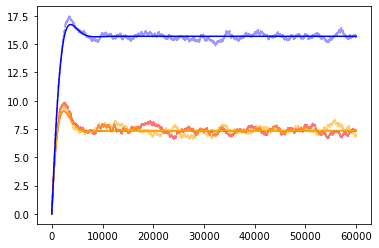

In [5]:
plt.plot(R_n[0,:], color='red', linestyle='--', alpha=.55)
plt.plot(R_ss[0,:], color='red')

plt.plot(R_n[1,:], color='orange', linestyle='--', alpha=.55)
plt.plot(R_ss[1,:], color='orange')

plt.plot(R_n[2,:], color='b', linestyle='--', alpha=.4)
plt.plot(R_ss[2,:], color='b')

plt.show()

In [6]:
get_ipython().run_line_magic('matplotlib', 'inline')

# Stable $E$ units, symmetric connectivity 

In [7]:
def cov_plot_symmetric_interactive(lowerW_EI, upperW_EI, lowerW_IE, upperW_IE, W_EE, W_II, k, tau, alpha):
    #range of J_EI
    W_EIs = np.linspace(lowerW_EI, upperW_EI, 100)
    W_IEs = np.linspace(lowerW_IE, upperW_IE, 100)

    # "cheat linearization"
    L = np.diag(np.repeat(k,3))

    # weights to fix
    W_E1E1 = W_EE
    W_E2E2 = W_EE

    # noise magnitudes
    c_ne = 1
    c_ni = 1

    # connection E1 <-> E2 
    W_E1E2 = alpha*W_E2E2
    W_E2E1 = alpha*W_E1E1

    # matrices
    sgn = np.block([
            [np.ones((3,1)), np.ones((3,1)), -np.ones((3,1))]
        ])
    Eye = np.eye(3)
    c_n = np.diagflat(np.block([
            [np.full((1,1), c_ne)],
            [np.full((1,1), c_ne)],
            [np.full((1,1), c_ni)]
        ]))
    D = c_n@L
    D = (1/tau)*np.sqrt(2)*D 

    K = len(W_EIs)

    # store covs/vars/corrs
    Covs_12 = np.zeros((K,K))
    Corrs_12 = np.zeros((K,K))
    Vars_1 = np.zeros((K,K))
    Vars_2 = np.zeros((K,K))
    Vars_3 = np.zeros((K,K))

    for i in range(K):
        for j in range(K):
            W_EI = W_EIs[i]
            W_IE = W_IEs[j]

            W = np.block([
                [W_E1E1, W_E1E2, W_EI],
                [W_E2E1, W_E2E2, W_EI],
                [W_IE, W_IE, W_II]
            ])

            # compute covariance matrix
            LW = L@(sgn*W)
            M = (1/tau)*(-Eye + LW)
            Minv = np.linalg.inv(M)
            Sigma = Minv @ D @ ((Minv@D).T)
            Corr = correlation_from_covariance(Sigma)

            Cov_12 = Sigma[0,1]
            Corr_12 = Corr[0,1]
            Var1 = Sigma[0,0]
            Var2 = Sigma[1,1]
            Var3 = Sigma[2,2]

            Covs_12[i,j] = Cov_12
            Corrs_12[i,j] = Corr_12
            Vars_1[i,j] = Var1 
            Vars_2[i,j] = Var2
            Vars_3[i,j] = Var3
            
    divnorm=colors.TwoSlopeNorm(vcenter=0)
    cmap=cm.get_cmap('PRGn')
    im=cm.ScalarMappable(norm=divnorm, cmap=cmap)
    
    plt.imshow(np.flip(Covs_12, axis=0), cmap=cmap, extent=[np.min(W_IEs), np.max(W_IEs), np.min(W_EIs), np.max(W_EIs)], norm=divnorm)
    plt.title(r'Cov$(E_1,E_2)$')
    plt.xlabel(r'$W_{I \leftarrow E}$')
    plt.ylabel(r'$W_{E \leftarrow I}$')
    plt.colorbar()

In [8]:
def var_plot_symmetric_interactive(lowerW_EI, upperW_EI, lowerW_IE, upperW_IE, W_EE, W_II, k, tau, alpha):
    #range of J_EI
    W_EIs = np.linspace(lowerW_EI, upperW_EI, 100)
    W_IEs = np.linspace(lowerW_IE, upperW_IE, 100)

    # "cheat linearization"
    L = np.diag(np.repeat(k,3))

    # weights to fix
    W_E1E1 = W_EE
    W_E2E2 = W_EE

    # noise magnitudes
    c_ne = 1
    c_ni = 1

    # connection E1 <-> E2 
    W_E1E2 = alpha*W_E2E2
    W_E2E1 = alpha*W_E1E1

    # matrices
    sgn = np.block([
            [np.ones((3,1)), np.ones((3,1)), -np.ones((3,1))]
        ])
    Eye = np.eye(3)
    c_n = np.diagflat(np.block([
            [np.full((1,1), c_ne)],
            [np.full((1,1), c_ne)],
            [np.full((1,1), c_ni)]
        ]))
    D = c_n@L
    D = (1/tau)*np.sqrt(2)*D 

    K = len(W_EIs)

    # store covs/vars/corrs
    Covs_12 = np.zeros((K,K))
    Corrs_12 = np.zeros((K,K))
    Vars_1 = np.zeros((K,K))
    Vars_2 = np.zeros((K,K))
    Vars_3 = np.zeros((K,K))

    for i in range(K):
        for j in range(K):
            W_EI = W_EIs[i]
            W_IE = W_IEs[j]

            W = np.block([
                [W_E1E1, W_E1E2, W_EI],
                [W_E2E1, W_E2E2, W_EI],
                [W_IE, W_IE, W_II]
            ])

            # compute covariance matrix
            LW = L@(sgn*W)
            M = (1/tau)*(-Eye + LW)
            Minv = np.linalg.inv(M)
            Sigma = Minv @ D @ ((Minv@D).T)
            Corr = correlation_from_covariance(Sigma)

            Cov_12 = Sigma[0,1]
            Corr_12 = Corr[0,1]
            Var1 = Sigma[0,0]
            Var2 = Sigma[1,1]
            Var3 = Sigma[2,2]

            Covs_12[i,j] = Cov_12
            Corrs_12[i,j] = Corr_12
            Vars_1[i,j] = Var1 
            Vars_2[i,j] = Var2
            Vars_3[i,j] = Var3
            
    plt.imshow(np.flip(Vars_1, axis=0), extent=[np.min(W_IEs), np.max(W_IEs), np.min(W_EIs), np.max(W_EIs)])
    plt.title(r'Var$(E_1)$')
    plt.xlabel(r'$W_{I \leftarrow E}$')
    plt.ylabel(r'$W_{E \leftarrow I}$')
    plt.colorbar()

In [9]:
def corr_plot_symmetric_interactive(lowerW_EI, upperW_EI, lowerW_IE, upperW_IE, W_EE, W_II, k, tau, alpha):
    #range of J_EI
    W_EIs = np.linspace(lowerW_EI, upperW_EI, 100)
    W_IEs = np.linspace(lowerW_IE, upperW_IE, 100)

    # "cheat linearization"
    L = np.diag(np.repeat(k,3))

    # weights to fix
    W_E1E1 = W_EE
    W_E2E2 = W_EE

    # noise magnitudes
    c_ne = 1
    c_ni = 1


    # all timescales equal
    #tau = 15

    # connection E1 <-> E2 
    W_E1E2 = alpha*W_E2E2
    W_E2E1 = alpha*W_E1E1

    # matrices
    sgn = np.block([
            [np.ones((3,1)), np.ones((3,1)), -np.ones((3,1))]
        ])
    Eye = np.eye(3)
    c_n = np.diagflat(np.block([
            [np.full((1,1), c_ne)],
            [np.full((1,1), c_ne)],
            [np.full((1,1), c_ni)]
        ]))
    D = c_n@L
    D = (1/tau)*np.sqrt(2)*D 

    K = len(W_EIs)

    # store covs/vars/corrs
    Covs_12 = np.zeros((K,K))
    Corrs_12 = np.zeros((K,K))
    Vars_1 = np.zeros((K,K))
    Vars_2 = np.zeros((K,K))
    Vars_3 = np.zeros((K,K))

    for i in range(K):
        for j in range(K):
            W_EI = W_EIs[i]
            W_IE = W_IEs[j]

            W = np.block([
                [W_E1E1, W_E1E2, W_EI],
                [W_E2E1, W_E2E2, W_EI],
                [W_IE, W_IE, W_II]
            ])

            # compute covariance matrix
            LW = L@(sgn*W)
            M = (1/tau)*(-Eye + LW)
            Minv = np.linalg.inv(M)
            Sigma = Minv @ D @ ((Minv@D).T)
            Corr = correlation_from_covariance(Sigma)

            Cov_12 = Sigma[0,1]
            Corr_12 = Corr[0,1]
            Var1 = Sigma[0,0]
            Var2 = Sigma[1,1]
            Var3 = Sigma[2,2]

            Covs_12[i,j] = Cov_12
            Corrs_12[i,j] = Corr_12
            Vars_1[i,j] = Var1 
            Vars_2[i,j] = Var2
            Vars_3[i,j] = Var3
    
    
    # plotting
    divnorm=colors.TwoSlopeNorm(vcenter=0)
    cmap=cm.get_cmap('seismic')
    im=cm.ScalarMappable(norm=divnorm, cmap=cmap)
    plt.imshow(np.flip(Corrs_12, axis=0), cmap=cmap, extent=[np.min(W_IEs), np.max(W_IEs), np.min(W_EIs), np.max(W_EIs)], norm=divnorm)
    plt.title(r'Corr$(E_1,E_2)$')
    plt.xlabel(r'$W_{I \leftarrow E}$')
    plt.ylabel(r'$W_{E \leftarrow I}$')
    plt.colorbar()

In [10]:
interactive_plot = interactive(cov_plot_symmetric_interactive, lowerW_EI=fixed(0), upperW_EI=fixed(1), lowerW_IE=fixed(0), upperW_IE=fixed(1), W_EE=(0,1,0.05), W_II=(0,1,0.05), k=fixed(1), tau=fixed(15), alpha=(0,1,0.01))
interactive_plot

interactive(children=(FloatSlider(value=0.0, description='W_EE', max=1.0, step=0.05), FloatSlider(value=0.0, d…

In [11]:
interactive_plot = interactive(var_plot_symmetric_interactive, lowerW_EI=fixed(0), upperW_EI=fixed(1), lowerW_IE=fixed(0), upperW_IE=fixed(1), W_EE=(0,1,0.05), W_II=(0,1,0.05), k=fixed(1), tau=fixed(15), alpha=(0,1,0.01))
interactive_plot

interactive(children=(FloatSlider(value=0.0, description='W_EE', max=1.0, step=0.05), FloatSlider(value=0.0, d…

In [12]:
interactive_plot = interactive(corr_plot_symmetric_interactive, lowerW_EI=fixed(0), upperW_EI=fixed(1), lowerW_IE=fixed(0), upperW_IE=fixed(1), W_EE=(0,1,0.05), W_II=(0,1,0.05), k=fixed(1), tau=fixed(15), alpha=(0,1,0.01))
interactive_plot

interactive(children=(FloatSlider(value=0.0, description='W_EE', max=1.0, step=0.05), FloatSlider(value=0.0, d…

# Stable $E$ units, asymmetric connectivity

In [13]:
def cov_plot_asymmetric_case1(W_E1E1, W_E2E2, W_II, lowerW_E1I, upperW_E1I, lowerW_IE1, upperW_IE1, k, tau, alpha, delta):
    #range of J_EI
    W_E1Is = np.linspace(lowerW_E1I, upperW_E1I, 100)
    W_IE1s = np.linspace(lowerW_IE1, upperW_IE1, 100)

    # "cheat linearization"
    L = np.diag(np.repeat(k,3))

    # weights to fix
    #W_E1E1 = W_EE
    #W_E2E2 = W_EE

    # noise magnitudes
    c_ne = 1
    c_ni = 1

    # connection E1 <-> E2 
    W_E1E2 = alpha*W_E2E2
    W_E2E1 = alpha*W_E1E1

    # matrices
    sgn = np.block([
            [np.ones((3,1)), np.ones((3,1)), -np.ones((3,1))]
        ])
    Eye = np.eye(3)
    c_n = np.diagflat(np.block([
            [np.full((1,1), c_ne)],
            [np.full((1,1), c_ne)],
            [np.full((1,1), c_ni)]
        ]))
    D = c_n@L
    D = (1/tau)*np.sqrt(2)*D 

    K = len(W_E1Is)

    # store covs/vars/corrs
    Covs_12 = np.zeros((K,K))
    Corrs_12 = np.zeros((K,K))
    Vars_1 = np.zeros((K,K))
    Vars_2 = np.zeros((K,K))
    Vars_3 = np.zeros((K,K))

    for i in range(K):
        for j in range(K):
            W_E1I = W_E1Is[i]
            W_IE1 = W_IE1s[j]
            W_E2I = W_E1I + delta 
            W_IE2 = W_IE1 + delta

            W = np.block([
                [W_E1E1, W_E1E2, W_E1I],
                [W_E2E1, W_E2E2, W_E2I],
                [W_IE1, W_IE2, W_II]
            ])

            # compute covariance matrix
            LW = L@(sgn*W)
            M = (1/tau)*(-Eye + LW)
            Minv = np.linalg.inv(M)
            Sigma = Minv @ D @ ((Minv@D).T)
            Corr = correlation_from_covariance(Sigma)

            Cov_12 = Sigma[0,1]
            Corr_12 = Corr[0,1]
            Var1 = Sigma[0,0]
            Var2 = Sigma[1,1]
            Var3 = Sigma[2,2]

            Covs_12[i,j] = Cov_12
            Corrs_12[i,j] = Corr_12
            Vars_1[i,j] = Var1 
            Vars_2[i,j] = Var2
            Vars_3[i,j] = Var3
            
    divnorm=colors.TwoSlopeNorm(vcenter=0)
    cmap=cm.get_cmap('PRGn')
    im=cm.ScalarMappable(norm=divnorm, cmap=cmap)
    
    plt.imshow(np.flip(Covs_12, axis=0), cmap=cmap, extent=[np.min(W_IE1s), np.max(W_IE1s), np.min(W_E1Is), np.max(W_E1Is)], norm=divnorm)
    plt.title(r'Cov$(E_1,E_2)$')
    plt.xlabel(r'$W_{I \leftarrow E_1}$')
    plt.ylabel(r'$W_{E_1 \leftarrow I}$')
    plt.colorbar()

In [14]:
def cov_plot_asymmetric_case2(W_E1E1, W_E2E2, W_II, lowerW_E1I, upperW_E1I, lowerW_IE2, upperW_IE2, k, tau, alpha, delta):
    #range of J_EI
    W_E1Is = np.linspace(lowerW_E1I, upperW_E1I, 100)
    W_IE2s = np.linspace(lowerW_IE2, upperW_IE2, 100)

    # "cheat linearization"
    L = np.diag(np.repeat(k,3))

    # noise magnitudes
    c_ne = 1
    c_ni = 1

    # connection E1 <-> E2 
    W_E1E2 = alpha*W_E2E2
    W_E2E1 = alpha*W_E1E1

    # matrices
    sgn = np.block([
            [np.ones((3,1)), np.ones((3,1)), -np.ones((3,1))]
        ])
    Eye = np.eye(3)
    c_n = np.diagflat(np.block([
            [np.full((1,1), c_ne)],
            [np.full((1,1), c_ne)],
            [np.full((1,1), c_ni)]
        ]))
    D = c_n@L
    D = (1/tau)*np.sqrt(2)*D 

    K = len(W_E1Is)

    # store covs/vars/corrs
    Covs_12 = np.zeros((K,K))
    Corrs_12 = np.zeros((K,K))
    Vars_1 = np.zeros((K,K))
    Vars_2 = np.zeros((K,K))
    Vars_3 = np.zeros((K,K))

    for i in range(K):
        for j in range(K):
            W_E1I = W_E1Is[i]
            W_IE2 = W_IE2s[j]
            W_E2I = W_E1I + delta 
            W_IE1 = W_IE2 + delta

            W = np.block([
                [W_E1E1, W_E1E2, W_E1I],
                [W_E2E1, W_E2E2, W_E2I],
                [W_IE1, W_IE2, W_II]
            ])

            # compute covariance matrix
            LW = L@(sgn*W)
            M = (1/tau)*(-Eye + LW)
            Minv = np.linalg.inv(M)
            Sigma = Minv @ D @ ((Minv@D).T)
            Corr = correlation_from_covariance(Sigma)

            Cov_12 = Sigma[0,1]
            Corr_12 = Corr[0,1]
            Var1 = Sigma[0,0]
            Var2 = Sigma[1,1]
            Var3 = Sigma[2,2]

            Covs_12[i,j] = Cov_12
            Corrs_12[i,j] = Corr_12
            Vars_1[i,j] = Var1 
            Vars_2[i,j] = Var2
            Vars_3[i,j] = Var3
            
    divnorm=colors.TwoSlopeNorm(vcenter=0)
    cmap=cm.get_cmap('PRGn')
    im=cm.ScalarMappable(norm=divnorm, cmap=cmap)
    
    plt.imshow(np.flip(Covs_12, axis=0), cmap=cmap, extent=[np.min(W_IE2s), np.max(W_IE2s), np.min(W_E1Is), np.max(W_E1Is)], norm=divnorm)
    plt.title(r'Cov$(E_1,E_2)$')
    plt.xlabel(r'$W_{I \leftarrow E_2}$')
    plt.ylabel(r'$W_{E_1 \leftarrow I}$')
    plt.colorbar()

In [15]:
def cov_plot_asymmetric_case3(W_E1E1, W_E2E2, W_II, lowerW_EI, upperW_EI, lowerW_IE2, upperW_IE2, k, tau, alpha, delta):
    #range of J_EI
    W_EIs = np.linspace(lowerW_EI, upperW_EI, 100)
    W_IE2s = np.linspace(lowerW_IE2, upperW_IE2, 100)

    # "cheat linearization"
    L = np.diag(np.repeat(k,3))

    # noise magnitudes
    c_ne = 1
    c_ni = 1

    # connection E1 <-> E2 
    W_E1E2 = alpha*W_E2E2
    W_E2E1 = alpha*W_E1E1

    # matrices
    sgn = np.block([
            [np.ones((3,1)), np.ones((3,1)), -np.ones((3,1))]
        ])
    Eye = np.eye(3)
    c_n = np.diagflat(np.block([
            [np.full((1,1), c_ne)],
            [np.full((1,1), c_ne)],
            [np.full((1,1), c_ni)]
        ]))
    D = c_n@L
    D = (1/tau)*np.sqrt(2)*D 

    K = len(W_EIs)

    # store covs/vars/corrs
    Covs_12 = np.zeros((K,K))
    Corrs_12 = np.zeros((K,K))
    Vars_1 = np.zeros((K,K))
    Vars_2 = np.zeros((K,K))
    Vars_3 = np.zeros((K,K))

    for i in range(K):
        for j in range(K):
            W_E1I = W_EIs[i]
            W_E2I = W_EIs[i]
            W_IE2 = W_IE2s[j]
            W_IE1 = W_IE2 + delta

            W = np.block([
                [W_E1E1, W_E1E2, W_E1I],
                [W_E2E1, W_E2E2, W_E2I],
                [W_IE1, W_IE2, W_II]
            ])

            # compute covariance matrix
            LW = L@(sgn*W)
            M = (1/tau)*(-Eye + LW)
            Minv = np.linalg.inv(M)
            Sigma = Minv @ D @ ((Minv@D).T)
            Corr = correlation_from_covariance(Sigma)

            Cov_12 = Sigma[0,1]
            Corr_12 = Corr[0,1]
            Var1 = Sigma[0,0]
            Var2 = Sigma[1,1]
            Var3 = Sigma[2,2]

            Covs_12[i,j] = Cov_12
            Corrs_12[i,j] = Corr_12
            Vars_1[i,j] = Var1 
            Vars_2[i,j] = Var2
            Vars_3[i,j] = Var3
            
    divnorm=colors.TwoSlopeNorm(vcenter=0)
    cmap=cm.get_cmap('PRGn')
    im=cm.ScalarMappable(norm=divnorm, cmap=cmap)
    
    plt.imshow(np.flip(Covs_12, axis=0), cmap=cmap, extent=[np.min(W_IE2s), np.max(W_IE2s), np.min(W_EIs), np.max(W_EIs)], norm=divnorm)
    plt.title(r'Cov$(E_1,E_2)$')
    plt.xlabel(r'$W_{I \leftarrow E_2}$')
    plt.ylabel(r'$W_{E_1 \leftarrow I}$')
    plt.colorbar()

In [16]:
interactive_plot = interactive(cov_plot_asymmetric_case1, 
                               W_E1E1=(0.1,1,0.05), W_E2E2=(0.1,1,0.05), W_II=(0.1,1,0.05),
                               lowerW_E1I=fixed(0), upperW_E1I=fixed(1), lowerW_IE1=fixed(0), upperW_IE1=fixed(1), 
                               k=fixed(1), tau=fixed(15), 
                               alpha=(0,1,0.01),
                               delta=(0,1,0.01))
interactive_plot

interactive(children=(FloatSlider(value=0.55, description='W_E1E1', max=1.0, min=0.1, step=0.05), FloatSlider(…

In [17]:
interactive_plot = interactive(cov_plot_asymmetric_case2, 
                               W_E1E1=(0.1,1,0.05), W_E2E2=(0.1,1,0.05), W_II=(0.1,1,0.05),
                               lowerW_E1I=fixed(0), upperW_E1I=fixed(1), lowerW_IE2=fixed(0), upperW_IE2=fixed(1), 
                               k=fixed(1), tau=fixed(15), 
                               alpha=(0,1,0.05),
                               delta=(0,1,0.05))
interactive_plot

interactive(children=(FloatSlider(value=0.55, description='W_E1E1', max=1.0, min=0.1, step=0.05), FloatSlider(…

In [18]:
interactive_plot = interactive(cov_plot_asymmetric_case3, 
                               W_E1E1=(0.1,1,0.05), W_E2E2=(0.1,1,0.05), W_II=(0.1,1,0.05),
                               lowerW_EI=fixed(0), upperW_EI=fixed(1), lowerW_IE2=fixed(0), upperW_IE2=fixed(1), 
                               k=fixed(1), tau=fixed(15), 
                               alpha=(0,1,0.01),
                               delta=(0,1,0.01))
interactive_plot

interactive(children=(FloatSlider(value=0.55, description='W_E1E1', max=1.0, min=0.1, step=0.05), FloatSlider(…